In [2]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from PIL import Image
import numpy as np
import cv2
import sys
nu_path = './devkit/python-sdk/'
sys.path.append(nu_path)
sys.path.append("../../trajectron")

nusc = NuScenes(version='v1.0-mini', dataroot='/home/wonder/datasets/nuscenes/mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
nusc.scene

[{'token': 'cc8c0bf57f984915a77078b10eb33198',
  'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
  'nbr_samples': 39,
  'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
  'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
  'name': 'scene-0061',
  'description': 'Parked truck, construction, intersection, turn left, following a van'},
 {'token': 'fcbccedd61424f1b85dcbf8f897f9754',
  'log_token': '53cf9c55dd8644bea67b9f009fc1ee38',
  'nbr_samples': 40,
  'first_sample_token': '3e8750f331d7499e9b5123e9eb70f2e2',
  'last_sample_token': '281b92269fd648d4b52d06ac06ca6d65',
  'name': 'scene-0103',
  'description': 'Many peds right, wait for turning car, long bike rack left, cyclist'},
 {'token': '6f83169d067343658251f72e1dd17dbc',
  'log_token': '881dd2f8aaec49b681eb54be5bf3b3e2',
  'nbr_samples': 41,
  'first_sample_token': '8687ba92abd3406aa797115b874ebeba',
  'last_sample_token': 'dcbe451d383e450786aaad04ab9d3790',
  'name': 'scene-0553',
  'description': 'Wait at intersect

In [4]:
scene = nusc.scene[1]

In [5]:
nusc.get('log', scene['log_token'])

{'token': '53cf9c55dd8644bea67b9f009fc1ee38',
 'logfile': 'n008-2018-08-01-15-16-36-0400',
 'vehicle': 'n008',
 'date_captured': '2018-08-01',
 'location': 'boston-seaport',
 'map_token': '36092f0b03a857c6a3403e25b4b7aab3'}

In [5]:
nusc.render_scene(scene['token'])

In [6]:
scene

{'token': 'fcbccedd61424f1b85dcbf8f897f9754',
 'log_token': '53cf9c55dd8644bea67b9f009fc1ee38',
 'nbr_samples': 40,
 'first_sample_token': '3e8750f331d7499e9b5123e9eb70f2e2',
 'last_sample_token': '281b92269fd648d4b52d06ac06ca6d65',
 'name': 'scene-0103',
 'description': 'Many peds right, wait for turning car, long bike rack left, cyclist'}

In [6]:
sample = nusc.get('sample', scene['first_sample_token'])

In [7]:
sample

{'token': '3e8750f331d7499e9b5123e9eb70f2e2',
 'timestamp': 1533151603547590,
 'prev': '',
 'next': '3950bd41f74548429c0f7700ff3d8269',
 'scene_token': 'fcbccedd61424f1b85dcbf8f897f9754',
 'data': {'RADAR_FRONT': '62fc4b9db2f14104ae681bc8afdd5631',
  'RADAR_FRONT_LEFT': '24ba6892937946f28e64a26febe81686',
  'RADAR_FRONT_RIGHT': '17d44aeb803649ac9a3b09ca288e4768',
  'RADAR_BACK_LEFT': 'd7b1dc5d4048477ea89482f0f3ba04d0',
  'RADAR_BACK_RIGHT': '567307635a67407c9ba269ab2777b8e5',
  'LIDAR_TOP': 'fdddd75ee1d94f14a09991988dab8b3e',
  'CAM_FRONT': '4f5e35aa6c6a426ca945e206fb2f4921',
  'CAM_FRONT_RIGHT': '5ed84fb1dbe24efcb00eb766a22d69d6',
  'CAM_BACK_RIGHT': '8fafdaa824b74553b1a08011d29baf20',
  'CAM_BACK': '1908fe7dc09c474ebc6ea23b4c1c5401',
  'CAM_BACK_LEFT': 'e4233736f4ba4fd5989684f0f1e84377',
  'CAM_FRONT_LEFT': '27f02b3e285d4ca18015535511520b3e'},
 'anns': ['c0571ecf3f9a461db18a70f9a6883e4f',
  '7381b60a2a9147518294969bf78412ec',
  'e912747998bb4485b44841c773d6ae7a',
  '404c7efea9604c3da

In [8]:
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot='/home/wonder/datasets/nuscenes/mini', map_name='boston-seaport') 

In [26]:
def fit_and_evaluate(traj, degree=1):
    # traj: list of (frame_id, [x, y, z])
    traj = sorted(traj, key=lambda x: x[0])
    t = np.array([fid for fid, _ in traj])
    x = np.array([pos[0] for _, pos in traj])
    y = np.array([pos[1] for _, pos in traj])

    # --- Removed normalization ---

    # Fit polynomial x(t), y(t) on original data
    px = np.polyfit(t, x, degree)
    py = np.polyfit(t, y, degree)
    x_fit = np.polyval(px, t)
    y_fit = np.polyval(py, t)
    mse = np.mean((x - x_fit)**2 + (y - y_fit)**2)

    # Quadratic mse
    px = np.polyfit(t, x, 2)
    py = np.polyfit(t, y, 2)
    x_quad_fit = np.polyval(px, t)
    y_quad_fit = np.polyval(py, t)
    mse_quad = np.mean((x - x_quad_fit)**2 + (y - y_quad_fit)**2)

    # R-squared and adjusted R-squared
    n = len(t)
    p = degree + 1  # number of parameters
    ss_tot = np.sum((x - x.mean())**2 + (y - y.mean())**2)
    ss_res = np.sum((x - x_fit)**2 + (y - y_fit)**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else r2

    # Linearity ratio: displacement / path length (on original data)
    pts = np.stack([x, y], axis=1)
    displacement = np.linalg.norm(pts[-1] - pts[0])
    path_length = np.sum(np.linalg.norm(pts[1:] - pts[:-1], axis=1))
    linearity = displacement / path_length if path_length > 1 else 1.0

    return {
        'mse': mse,
        'mse_quad': mse_quad,
        'r2': r2,
        'adj_r2': adj_r2,
        'linearity': linearity
    }

In [10]:
# Collect all pedestrian positions for the whole scene
pedestrian_trajs = dict()
for i in range(10):
    scene = nusc.scene[i]
    print(f"Processing scene {i}: {scene['description']}")
    sample_token = scene['first_sample_token']
    frame_id = 0
    pedestrian_trajs[i] = dict()

    while True:
        sample = nusc.get('sample', sample_token)
        for ann_token in sample['anns']:
            ann = nusc.get('sample_annotation', ann_token)
            if ann['category_name'] == 'human.pedestrian.adult':
                ped_id = ann['instance_token']
                if ped_id not in pedestrian_trajs[i]:
                    pedestrian_trajs[i][ped_id] = []
                pedestrian_trajs[i][ped_id].append((frame_id, ann['translation']))
        if sample['next'] == "":
            break
        sample_token = sample['next']
        frame_id += 1

    # Sort by frame_id to ensure correct order
    for ped_id in pedestrian_trajs[i].keys():
        ped_trajectory = [(frame_id, pos) for frame_id, pos in sorted(pedestrian_trajs[i][ped_id], key=lambda x: x[0])]
        pedestrian_trajs[i][ped_id] = ped_trajectory

Processing scene 0: Parked truck, construction, intersection, turn left, following a van
Processing scene 1: Many peds right, wait for turning car, long bike rack left, cyclist
Processing scene 2: Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller
Processing scene 3: Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles
Processing scene 4: Arrive at busy intersection, bus, wait at intersection, bicycle, peds
Processing scene 5: Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us
Processing scene 6: Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle
Processing scene 7: Night, big street, bus stop, high speed, construction vehicle
Processing scene 8: Night, after rain, many peds, PMD, ped with bag, jaywalker, truck, scooter
Processing scene 9: Night, peds in sidewalk, peds cross crosswalk, scooter, PMD, difficult lighting


In [27]:
# Example: analyze all pedestrian trajectories
results = {}
error_trajs = {}
for scene_id, ped in pedestrian_trajs.items():
    print(f"Analyzing scene {scene_id} with {len(ped)} pedestrians.")
    results[scene_id] = {}
    error_trajs[scene_id] = {}
    for ped_id, traj in ped.items():
        if len(traj) < 2:
            print(f"Skipping pedestrian {ped_id} in scene {scene_id} due to insufficient data points.")
            continue
        try:
            results[scene_id][ped_id] = fit_and_evaluate(traj, degree=1)
        except:
            print(f"Error processing trajectory for pedestrian {ped_id}")
            # Save the trajectory for debugging
            error_trajs[scene_id][ped_id] = traj

Analyzing scene 0 with 55 pedestrians.
Skipping pedestrian 85d771dc8b2049fc9155b376a73b2121 in scene 0 due to insufficient data points.
Skipping pedestrian 4c8ffcdaddb44fc0b4d42faeae50f083 in scene 0 due to insufficient data points.
Analyzing scene 1 with 42 pedestrians.
Analyzing scene 2 with 12 pedestrians.
Analyzing scene 3 with 4 pedestrians.
Analyzing scene 4 with 2 pedestrians.
Analyzing scene 5 with 10 pedestrians.
Analyzing scene 6 with 23 pedestrians.
Analyzing scene 7 with 0 pedestrians.
Analyzing scene 8 with 54 pedestrians.
Analyzing scene 9 with 11 pedestrians.


/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:19: RankWarning: Polyfit may be poorly conditioned
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:19: RankWarning: Polyfit may be poorly conditioned


In [14]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.map_expansion.map_api import NuScenesMap

for scene_id, ped in pedestrian_trajs.items():
    if len(ped) == 0:
        print(f"No pedestrian data for scene {scene_id}, skipping video generation.")
        continue
    scene = nusc.scene[scene_id]
    location = nusc.get('log', scene['log_token'])['location']
    nusc_map = NuScenesMap(dataroot='/home/wonder/datasets/nuscenes/mini', map_name=location)

    # Compute bounds
    all_x = []
    all_y = []
    for traj in ped.values():
        for _, pos in traj:
            all_x.append(pos[0])
            all_y.append(pos[1])
    if len(all_x) == 0 or len(all_y) == 0:
        print(f"Skipping scene {scene_id} (no pedestrian positions)")
        continue
    x_min = np.round(np.min(all_x) - 50)
    x_max = np.round(np.max(all_x) + 50)
    y_min = np.round(np.min(all_y) - 50)
    y_max = np.round(np.max(all_y) + 50)
    print(f"Scene {scene_id} bounds:\n x_min={x_min}\n x_max={x_max}\n y_min={y_min}\n y_max={y_max}")
    x_size = x_max - x_min
    y_size = y_max - y_min
    if x_size == 0 or y_size == 0:
        print(f"Skipping scene {scene_id} due to zero map patch size (x_size={x_size}, y_size={y_size})")
        continue

    center_x = x_min + 0.5 * x_size
    center_y = y_min + 0.5 * y_size
    patch_box = (center_x, center_y, x_size, y_size)
    patch_angle = 0
    canvas_size = (np.round(3 * y_size).astype(int), np.round(3 * x_size).astype(int))
    
    # Define the full color mapping for all possible layers
    nuscenes_layer_colors = {
        'drivable_area': [167, 158, 134],
        'road_segment': [255, 158, 0],
        'lane': [255, 61, 99],
        'ped_crossing': [255, 158, 232],
        'walkway': [255, 255, 255],
        'stop_line': [255, 0, 255],
        'carpark_area': [112, 128, 144],
        'road_divider': [0, 0, 0],
        'lane_divider': [255, 255, 0],
        'traffic_light': [0, 255, 255],
    }

    # The layers you want to request
    layers = [
        'drivable_area', 'road_segment', 'lane', 'ped_crossing', 'walkway',
        'stop_line', 'carpark_area', 'road_divider', 'lane_divider', 'traffic_light'
    ]

    # Get map mask as numpy array (channels, H, W)
    map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layers, canvas_size)

    # Compose RGB image using the color map, matching only present layers
    map_img = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)
    present_layers = layers[:map_mask.shape[0]]
    for i, layer in enumerate(present_layers):
        color = nuscenes_layer_colors[layer]
        mask = map_mask[i].astype(bool)
        map_img[mask] = color

    map_img_bgr = cv2.cvtColor(map_img, cv2.COLOR_RGB2BGR)
    map_img_bgr = np.rot90(map_img_bgr, k=0)  # Rotate to match the map orientation

    # 3. Prepare video writer
    height, width, _ = map_img.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'pedestrian_trajectories_{scene_id}.mp4', fourcc, 2, (width, height))

    all_frame_ids = set()
    for traj in ped.values():
        all_frame_ids.update([frame_id for frame_id, _ in traj])
    all_frame_ids = sorted(all_frame_ids)

    # --- Extract ego poses for the scene ---
    ego_poses = []
    sample_token = scene['first_sample_token']
    while True:
        sample = nusc.get('sample', sample_token)
        ego_pose = nusc.get('ego_pose', nusc.get('sample_data', sample['data']['LIDAR_TOP'])['ego_pose_token'])
        x_ego, y_ego = ego_pose['translation'][0], ego_pose['translation'][1]
        ego_poses.append((sample['timestamp'], x_ego, y_ego))
        if sample['next'] == "":
            break
        sample_token = sample['next']

    # Map from frame_id to ego pose (assuming frame_id increments with each sample)
    ego_pose_by_frame = {i: (x, y) for i, (_, x, y) in enumerate(ego_poses)}

    # ... inside your frame loop ...
    for frame_id in all_frame_ids:
        frame = map_img_bgr.copy()
        # Draw ego pose for this frame if available
        if frame_id in ego_pose_by_frame:
            x_ego, y_ego = ego_pose_by_frame[frame_id]
            px_ego = int((x_ego - x_min) / x_size * width)
            py_ego = int((y_ego - y_min) / y_size * height)
            cv2.circle(frame, (px_ego, py_ego), 7, (0, 255, 255), -1)  # yellow circle for ego
        # ...existing pedestrian drawing code...
        for ped_id, traj in ped.items():
            # Draw trajectory line up to current frame
            past_points = [(pos[0] - x_min, pos[1] - y_min) for fid, pos in traj if fid <= frame_id]
            if len(past_points) > 1:
                pts = np.array([
                    [
                        int(x / x_size * width),
                        int((y / y_size) * height)
                    ] for x, y in past_points
                ], np.int32)
                cv2.polylines(frame, [pts], isClosed=False, color=(0, 255, 0), thickness=2)
            # Draw current position as a blue dot
            pos = [pos for fid, pos in traj if fid == frame_id]
            if pos:
                x, y, _ = pos[0]
                x = x - x_min
                y = y - y_min
                px = int(x / x_size * width)
                py = int((y / y_size) * height)
                cv2.circle(frame, (px, py), 5, (0, 0, 255), -1)
        out.write(frame[..., ::-1])  # Convert RGB to BGR for OpenCV

    out.release()
    print(f"Video saved as pedestrian_trajectories_{scene_id}.mp4")

Scene 0 bounds:
 x_min=290.0
 x_max=530.0
 y_min=1047.0
 y_max=1272.0


/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1501: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1502: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


Video saved as pedestrian_trajectories_0.mp4
Scene 1 bounds:
 x_min=530.0
 x_max=760.0
 y_min=1523.0
 y_max=1732.0
Video saved as pedestrian_trajectories_1.mp4
Scene 2 bounds:
 x_min=1191.0
 x_max=1371.0
 y_min=965.0
 y_max=1147.0
Video saved as pedestrian_trajectories_2.mp4
Scene 3 bounds:
 x_min=1674.0
 x_max=1914.0
 y_min=808.0
 y_max=931.0
Video saved as pedestrian_trajectories_3.mp4
Scene 4 bounds:
 x_min=254.0
 x_max=362.0
 y_min=633.0
 y_max=746.0
Video saved as pedestrian_trajectories_4.mp4
Scene 5 bounds:
 x_min=1741.0
 x_max=1923.0
 y_min=2426.0
 y_max=2621.0
Video saved as pedestrian_trajectories_5.mp4
Scene 6 bounds:
 x_min=644.0
 x_max=784.0
 y_min=1729.0
 y_max=1881.0
Video saved as pedestrian_trajectories_6.mp4
No pedestrian data for scene 7, skipping video generation.
Scene 8 bounds:
 x_min=1408.0
 x_max=1592.0
 y_min=1042.0
 y_max=1306.0
Video saved as pedestrian_trajectories_8.mp4
Scene 9 bounds:
 x_min=1228.0
 x_max=1402.0
 y_min=844.0
 y_max=973.0
Video saved as ped

In [22]:
cv2.destroyAllWindows()

In [28]:
for ped_id, res in results[1].items():
    print(f"Pedestrian {str(ped_id)}: Linear MSE={res['mse']:.2f}, Quadratic MSE={res['mse_quad']:.2f}, R-squared={res['r2']:.2f}, "
          f"Adjusted R-squared={res['adj_r2']:.2f}, Linearity={res['linearity']:.2f}")

Pedestrian ab8d210d019b44abae3c4e0eee6ce8ba: Linear MSE=0.03, Quadratic MSE=0.01, R-squared=1.00, Adjusted R-squared=1.00, Linearity=1.00
Pedestrian 3b19bb63d0924f4da3034819357d6c8b: Linear MSE=0.04, Quadratic MSE=0.01, R-squared=1.00, Adjusted R-squared=1.00, Linearity=1.00
Pedestrian 68a40df2846e4298af0417ea12721b5c: Linear MSE=0.00, Quadratic MSE=0.00, R-squared=1.00, Adjusted R-squared=1.00, Linearity=1.00
Pedestrian ab2c41511fd1408197b718a4bda692ac: Linear MSE=0.02, Quadratic MSE=0.02, R-squared=0.98, Adjusted R-squared=0.97, Linearity=1.00
Pedestrian fa107c6dd0dc4d15b94b86cbf5b990c0: Linear MSE=0.02, Quadratic MSE=0.02, R-squared=1.00, Adjusted R-squared=1.00, Linearity=1.00
Pedestrian f1010738ac3a4f56b936fa3a077571b5: Linear MSE=0.08, Quadratic MSE=0.07, R-squared=1.00, Adjusted R-squared=1.00, Linearity=0.98
Pedestrian ead6a822f86c432481c0a9d2e4e4f827: Linear MSE=0.10, Quadratic MSE=0.02, R-squared=0.99, Adjusted R-squared=0.99, Linearity=0.99
Pedestrian 99fbf1b9bf474215a4e8ad5

In [29]:
non_canonical_trajs = {}
for scene_id, ped in pedestrian_trajs.items():
    res = results[scene_id]
    non_canonical_trajs[scene_id] = {}
    for ped_id, traj in ped.items():
        if ped_id in res:
            mse_linear = res[ped_id]['mse']
            r2 = res[ped_id]['r2']
            adj_r2 = res[ped_id]['adj_r2']
            linearity = res[ped_id]['linearity']
            if linearity < 0.9:
                non_canonical_trajs[scene_id][ped_id] = traj

x_min_nc = {}
x_max_nc = {}
y_min_nc = {}
y_max_nc = {}
for scene_id, ped in non_canonical_trajs.items():
    all_x = []
    all_y = []
    print(f"Processing scene {scene_id} for bounds calculation")
    for traj in ped.values():
        for _, pos in traj:
            all_x.append(pos[0])
            all_y.append(pos[1])
    if len(all_x) == 0 or len(all_y) == 0:
        print(f"Skipping scene {scene_id} (no pedestrian positions)")
        continue
    x_min_nc[scene_id] = np.round(np.min(all_x) - 50)
    x_max_nc[scene_id] = np.round(np.max(all_x) + 50)
    y_min_nc[scene_id] = np.round(np.min(all_y) - 50)
    y_max_nc[scene_id] = np.round(np.max(all_y) + 50)

Processing scene 0 for bounds calculation
Processing scene 1 for bounds calculation
Processing scene 2 for bounds calculation
Skipping scene 2 (no pedestrian positions)
Processing scene 3 for bounds calculation
Skipping scene 3 (no pedestrian positions)
Processing scene 4 for bounds calculation
Skipping scene 4 (no pedestrian positions)
Processing scene 5 for bounds calculation
Skipping scene 5 (no pedestrian positions)
Processing scene 6 for bounds calculation
Processing scene 7 for bounds calculation
Skipping scene 7 (no pedestrian positions)
Processing scene 8 for bounds calculation
Processing scene 9 for bounds calculation


In [30]:
all_trajs = {}
for scene_id, ped in pedestrian_trajs.items():
    res = results[scene_id]
    all_trajs[scene_id] = {}
    for ped_id, traj in ped.items():
        if ped_id in res:
            all_trajs[scene_id][ped_id] = traj

x_min_all = {}
x_max_all = {}
y_min_all = {}
y_max_all = {}
for scene_id, ped in all_trajs.items():
    all_x = []
    all_y = []
    print(f"Processing scene {scene_id} for bounds calculation")
    for traj in ped.values():
        for _, pos in traj:
            all_x.append(pos[0])
            all_y.append(pos[1])
    if len(all_x) == 0 or len(all_y) == 0:
        print(f"Skipping scene {scene_id} (no pedestrian positions)")
        continue
    x_min_all[scene_id] = np.round(np.min(all_x) - 50)
    x_max_all[scene_id] = np.round(np.max(all_x) + 50)
    y_min_all[scene_id] = np.round(np.min(all_y) - 50)
    y_max_all[scene_id] = np.round(np.max(all_y) + 50)

Processing scene 0 for bounds calculation
Processing scene 1 for bounds calculation
Processing scene 2 for bounds calculation
Processing scene 3 for bounds calculation
Processing scene 4 for bounds calculation
Processing scene 5 for bounds calculation
Processing scene 6 for bounds calculation
Processing scene 7 for bounds calculation
Skipping scene 7 (no pedestrian positions)
Processing scene 8 for bounds calculation
Processing scene 9 for bounds calculation


/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


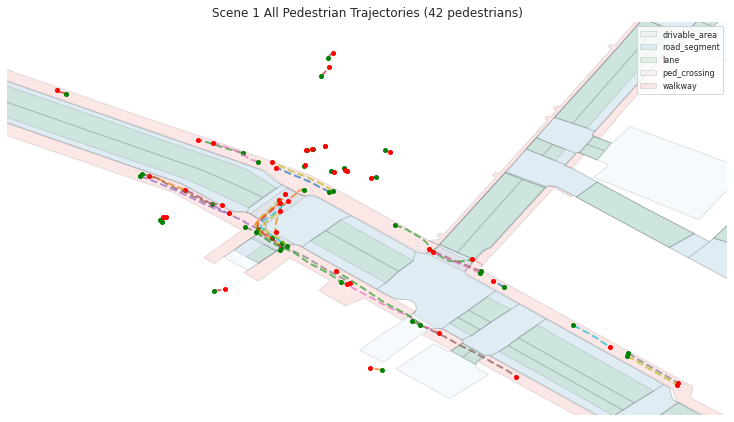

In [44]:
# Plot all pedestrian trajectories for a scene (static, qualitative style)

import matplotlib.pyplot as plt
from nuscenes.map_expansion.map_api import NuScenesMap

scene_id = 1  # Change as needed
ped = all_trajs[scene_id]
if len(ped) == 0:
    print(f"No pedestrian data for scene {scene_id}, skipping plot.")
else:
    scene = nusc.scene[scene_id]
    location = nusc.get('log', scene['log_token'])['location']
    nusc_map = NuScenesMap(dataroot='/home/wonder/datasets/nuscenes/mini', map_name=location)
    my_patch = (x_min_all[scene_id], y_min_all[scene_id], x_max_all[scene_id], y_max_all[scene_id])
    layers = ['drivable_area', 'road_segment', 'lane', 'ped_crossing', 'walkway']

    fig, ax = nusc_map.render_map_patch(my_patch, layer_names=layers, figsize=(10, 6), alpha=0.1, render_egoposes_range=False)

    # Plot all pedestrian trajectories
    for ped_id, traj in ped.items():
        xs = [pos[0] for _, pos in traj]
        ys = [pos[1] for _, pos in traj]
        ax.plot(xs, ys, '--', alpha=0.7, linewidth=2)

        # Optionally, highlight start and end
        ax.plot(xs[0], ys[0], 'go', markersize=4, label=None)  # Start
        ax.plot(xs[-1], ys[-1], 'ro', markersize=4, label=None) # End

    ax.set_xlim((x_min_all[scene_id]+40, x_max_all[scene_id]-40))
    ax.set_ylim((y_min_all[scene_id]+40, y_max_all[scene_id]-40))
    ax.set_title(f"Scene {scene_id} All Pedestrian Trajectories (42 pedestrians)")
    ax.legend(fontsize=8, loc='upper right', frameon=True)
    ax.axis('off')
    fig.tight_layout()
    plt.show()

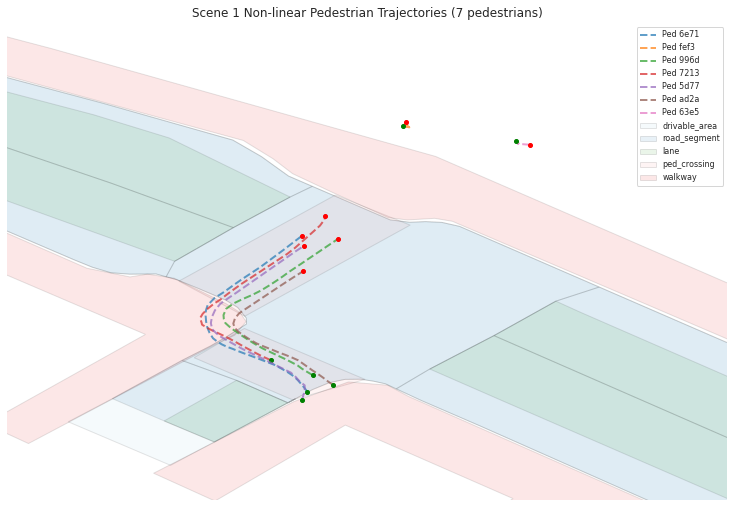

In [41]:
# Plot all non-canonical pedestrian trajectories for a scene (static, qualitative style)

import matplotlib.pyplot as plt
from nuscenes.map_expansion.map_api import NuScenesMap

scene_id = 1  # Change as needed
ped = non_canonical_trajs[scene_id]
if len(ped) == 0:
    print(f"No pedestrian data for scene {scene_id}, skipping plot.")
else:
    scene = nusc.scene[scene_id]
    location = nusc.get('log', scene['log_token'])['location']
    nusc_map = NuScenesMap(dataroot='/home/wonder/datasets/nuscenes/mini', map_name=location)
    my_patch = (x_min_nc[scene_id], y_min_nc[scene_id], x_max_nc[scene_id], y_max_nc[scene_id])
    layers = ['drivable_area', 'road_segment', 'lane', 'ped_crossing', 'walkway']

    fig, ax = nusc_map.render_map_patch(my_patch, layer_names=layers, figsize=(10, 6), alpha=0.1, render_egoposes_range=False)

    # Plot all pedestrian trajectories
    for ped_id, traj in ped.items():
        xs = [pos[0] for _, pos in traj]
        ys = [pos[1] for _, pos in traj]
        ax.plot(xs, ys, '--', label=f'Ped {ped_id[:4]}', alpha=0.7, linewidth=2)

        # Optionally, highlight start and end
        ax.plot(xs[0], ys[0], 'go', markersize=4, label=None)  # Start
        ax.plot(xs[-1], ys[-1], 'ro', markersize=4, label=None) # End

    ax.set_xlim((x_min_nc[scene_id]+40, x_max_nc[scene_id]-40))
    ax.set_ylim((y_min_nc[scene_id]+40, y_max_nc[scene_id]-40))
    ax.set_title(f"Scene {scene_id} Non-linear Pedestrian Trajectories (7 pedestrians)")
    ax.legend(fontsize=8, loc='upper right', frameon=True)
    ax.axis('off')
    plt.show()

In [70]:
for scene_id, ped in non_canonical_trajs.items():
    if len(ped) == 0:
        print(f"No pedestrian data for scene {scene_id}, skipping video generation.")
        continue
    scene = nusc.scene[scene_id]
    location = nusc.get('log', scene['log_token'])['location']
    nusc_map = NuScenesMap(dataroot='/home/wonder/datasets/nuscenes/mini', map_name=location)
    # 1. Get map patch as an image
    my_patch = (x_min_nc[scene_id], y_min_nc[scene_id], x_max_nc[scene_id], y_max_nc[scene_id])
    layers = ['drivable_area', 'road_segment', 'lane', 'ped_crossing', 'walkway']
    fig, ax = nusc_map.render_map_patch(my_patch, figsize=(10,10), alpha=0.7, render_egoposes_range=False)
    fig.canvas.draw()
    map_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    map_img = map_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    # 2. Prepare video writer
    height, width, _ = map_img.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'non_canonical_trajectories_{scene_id}.mp4', fourcc, 2, (width, height))

    all_frame_ids = set()
    for traj in ped.values():
        all_frame_ids.update([frame_id for frame_id, _ in traj])
    all_frame_ids = sorted(all_frame_ids)

    for frame_id in all_frame_ids:
        frame = map_img.copy()
        for ped_id, traj in ped.items():
            # Draw trajectory line up to current frame
            past_points = [(pos[0], pos[1]) for fid, pos in traj if fid <= frame_id]
            if len(past_points) > 1:
                pts = np.array([
                    [
                        int((x - x_min_nc[scene_id]) / (x_max_nc[scene_id] - x_min_nc[scene_id]) * width),
                        int(height - (y - y_min_nc[scene_id]) / (y_max_nc[scene_id] - y_min_nc[scene_id]) * height)
                    ] for x, y in past_points
                ], np.int32)
                cv2.polylines(frame, [pts], isClosed=False, color=(0, 255, 0), thickness=2)
            # Draw current position as a red dot
            pos = [pos for fid, pos in traj if fid == frame_id]
            if pos:
                x, y, _ = pos[0]
                px = int((x - x_min_nc[scene_id]) / (x_max_nc[scene_id] - x_min_nc[scene_id]) * width)
                py = int(height - (y - y_min_nc[scene_id]) / (y_max_nc[scene_id] - y_min_nc[scene_id]) * height)
                cv2.circle(frame, (px, py), 5, (0, 0, 255), -1)
        
        out.write(frame[..., ::-1])  # Convert RGB to BGR for OpenCV

    out.release()
    print(f"Video saved as non_canonical_trajectories_{scene_id}.mp4")

/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


Video saved as non_canonical_trajectories_0.mp4
Video saved as non_canonical_trajectories_1.mp4
No pedestrian data for scene 2, skipping video generation.
No pedestrian data for scene 3, skipping video generation.
No pedestrian data for scene 4, skipping video generation.
No pedestrian data for scene 5, skipping video generation.
Video saved as non_canonical_trajectories_6.mp4
No pedestrian data for scene 7, skipping video generation.
Video saved as non_canonical_trajectories_8.mp4
Video saved as non_canonical_trajectories_9.mp4


In [51]:
test_scene = nusc.scene[3]
nusc.render_scene(test_scene['token'])

In [36]:
for i in range(10):
    scene = nusc.scene[i]
    print(f"{i}: {scene['description']}")
    log = nusc.get('log', scene['log_token'])
    print(f"  Log: {log['location']}")

0: Parked truck, construction, intersection, turn left, following a van
  Log: singapore-onenorth
1: Many peds right, wait for turning car, long bike rack left, cyclist
  Log: boston-seaport
2: Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller
  Log: boston-seaport
3: Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles
  Log: boston-seaport
4: Arrive at busy intersection, bus, wait at intersection, bicycle, peds
  Log: boston-seaport
5: Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us
  Log: singapore-queenstown
6: Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle
  Log: singapore-queenstown
7: Night, big street, bus stop, high speed, construction vehicle
  Log: singapore-hollandvillage
8: Night, after rain, many peds, PMD, ped with bag, jaywalker, truck, scooter
  Log: singapore-hollandvillage
9: Night, peds in sidewalk, 

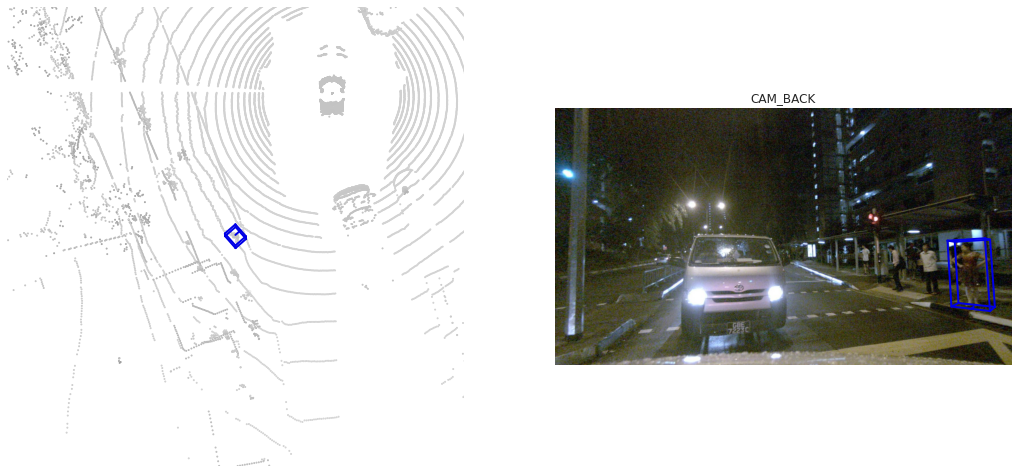

In [55]:
nusc.render_instance('0b2ba0a3a3874e4a9863541a7a65ec00')

In [9]:
import dill
with open('../processed/nuScenes_train_mini_full.pkl', 'rb') as f:
    data = dill.load(f, encoding='latin1')

In [13]:
data.pedestrians

AttributeError: 'Environment' object has no attribute 'pedestrians'

In [12]:
data.scenes[0]

Scene: Duration: 19.0s, Nodes: 80, Map: Yes.

In [14]:
sample = nusc.get('sample', scene['first_sample_token'])
for ann_token in sample['anns']:
    ann = nusc.get('sample_annotation', ann_token)
    if 'pedestrian' in ann['category_name']:
        print("Pedestrian annotation:")
        print(ann)
        break

Pedestrian annotation:
{'token': 'ef63a697930c4b20a6b9791f423351da', 'sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5', 'visibility_token': '1', 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'], 'translation': [373.256, 1130.419, 0.8], 'size': [0.621, 0.669, 1.642], 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616], 'prev': '', 'next': '7987617983634b119e383d8a29607fd7', 'num_lidar_pts': 1, 'num_radar_pts': 0, 'category_name': 'human.pedestrian.adult'}


In [3]:
for scene in nusc.scene:
    print(f"Scene {scene['token']}: {scene['name']}")

Scene cc8c0bf57f984915a77078b10eb33198: scene-0061
Scene fcbccedd61424f1b85dcbf8f897f9754: scene-0103
Scene 6f83169d067343658251f72e1dd17dbc: scene-0553
Scene bebf5f5b2a674631ab5c88fd1aa9e87a: scene-0655
Scene 2fc3753772e241f2ab2cd16a784cc680: scene-0757
Scene c5224b9b454b4ded9b5d2d2634bbda8a: scene-0796
Scene 325cef682f064c55a255f2625c533b75: scene-0916
Scene d25718445d89453381c659b9c8734939: scene-1077
Scene de7d80a1f5fb4c3e82ce8a4f213b450a: scene-1094
Scene e233467e827140efa4b42d2b4c435855: scene-1100
